### Import dependencies

In [0]:
# Библиотека для отрисовки картинок
import matplotlib.pyplot as plt 
# Магическое слово для отрисовки их в юпитер ноутбуке
%matplotlib inline

# Для повторяемости результатов
RANDOM_SEED = 42

# Для нейронок
import keras
import tensorflow as tf
# Для работы с предиктами нейронки
import numpy as np
# Наша метрика
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Фиксируем рэндом сид для повторяемости результатов
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

Using TensorFlow backend.


### Prepare data

In [0]:
# Загружаем датасет MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Скалируем/Нормализуем данные (они были от 0 до 255, а стали от 0 до 1)
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

11493376/11490434 [==============================] - 1s 0us/step


2


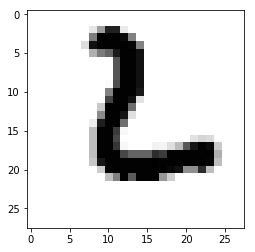

In [0]:
# Поменяйте номер ниже, чтобы посмотреть на различные примеры из тестового датасета
picture_num = 1337

plt.imshow(X_test[picture_num], cmap="Greys"); 
print(y_test[picture_num])

In [0]:
def flatten_images(x):
    # Функция делает из прямоугольных изображений плоские, вытянутые в вектор длиной 28*28 = 784
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

# "Плющим" все датасеты
X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

def one_hot_labels(y):
    # Функция делает из ответов вида 1, 4, 7, 9 их one hot представление для подачи в нейронку
    result = np.zeros((y.size, 10))
    result[np.arange(y.size), y] = 1
    return result

# "Ванхотим" все ответы 
y_train_one_hot = one_hot_labels(y_train)
y_test_one_hot = one_hot_labels(y_test)

### Building and training a model

In [0]:
# Импортируем заготовку для нашей сетки
from keras.models import Sequential
# И полносвязные слои
from keras.layers import Dense

# Создаем пустую сетку
net = Sequential()

# Наполняем ее 3 внутренними слоями
net.add(Dense(512, activation='relu', input_dim=28*28)) 
net.add(Dense(128, activation='relu')) 
net.add(Dense(32, activation='relu')) 

# + 1 выходной с активацией софтмакс
net.add(Dense(10, activation='softmax')) 

# Собираем в кучу нашу модель, указываем ей ошибку для минимизации (категориальная кроссэнтропия)
# Также выбираем оптимизатор (любимый Адам) и метрику, которая будет показываться (точность)
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Показываем какие у нас слои есть и сколько в них весов
net.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 472,042
Trainable params: 472,042
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:


"""
т.к. у нас в распоряжении данные входным размером = 784, 
размерность первого слоя (если идти по степеням 2) будет равна 512.
Затем, опускаясь все ниже, размерности слоев будут так же уменьшаться по степеням двойки.
В итоге максимальное количество слоев сетки = 6 (от 512 нейронов до 16 + softmax-активация)

"""


"""
 n_layers_max - максимальное значение количества слоев
 n_epoch_max - максимальное количество эпох
 
 """


# функция завершает свою работу при нахождении первого скора, превышающего заложенный
def make_better(n_layers_max, n_epoch_max, X_train, y_train, X_test, y_t):
  
  
  score = 0.981
  checkpoint = ModelCheckpoint(filepath='baest_model.h5', save_best_only=True, mode='max')
  earlystopper = EarlyStopping(monitor='val_acc', patience=2, mode='max', baseline=score, restore_best_weights=True)
  callbacks = [checkpoint, earlystopper]
  
  
  for i in range(3, n_layers_max):
    net = Sequential()
  
    s = 9
    net.add(Dense(int(2**s), activation='relu', input_dim=28*28))
  
  
    for j in range(i-1):
      
        s -= 1
        net.add(Dense(int(2**s), activation='relu'))
      
      
    net.add(Dense(10, activation='softmax')) 
    net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  
    for f in range(10,n_epoch_max+1):
      print('number of epoch ... ', f)
      net.summary()
      history = net.fit(X_train, y_train_one_hot, batch_size=128, epochs=f, 
                  verbose=2, callbacks = callbacks)
      
      y_pred_one_hot = net.predict(X_test)
      y_pred_labels = np.argmax(y_pred_one_hot, axis=1)
      
      your_score = accuracy_score(y_test, y_pred_labels)
      if your_score > score:
        print('Your accuracy on a test dataset =', your_score)
        print('best n_epoch = ', f)
        print('best n_layers = ', i)
        break
    break
    

In [0]:
make_better(n_layers_max=6, n_epoch_max=20, X_train=X_train, y_train=y_train_one_hot, X_test=X_test, y_t=y_test_one_hot)

number of epoch ...  10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 3s - loss: 0.2331 - acc: 0.9313
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 3s - loss: 0.0847 - acc: 0.9741
Epoch 3/10
 - 3s - loss: 0.0550 - acc: 0.9826
Epoch 4/10
 - 3s - loss: 0.0406 - acc: 0.9869
Epoch 5/10
 - 3s - loss: 0.0301 - acc: 0.9900
Epoch 6/10
 - 3s - loss: 0.0257 - acc: 0.9918
Epoch 7/10
 - 3s - loss: 0.0225 - acc: 0.9925
Epoch 8/10
 - 3s - loss: 0.0211 - acc: 0.9930
Epoch 9/10
 - 3s - loss: 0.0148 - acc: 0.9954
Epoch 10/10
 - 3s - loss: 0.0145 - acc: 0.9953
number of epoch ...  11
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 10)     

### Getting a test score

In [0]:
# Делаем предикт сеткой и получаем One Hot матрицу
y_pred_one_hot = net.predict(X_test)
# Преобразовываем ее в ответы
y_pred_labels = np.argmax(y_pred_one_hot, axis=1)

# Считаем ваш скор
your_score = accuracy_score(y_test, y_pred_labels)
print('Your accuracy on a test dataset =', your_score)

Your accuracy on a test dataset = 0.9824
